# E: Introducción al trabajo con imágenes astronómicas (`FITS`)

El tipo de archivo de imágenes que usaremos es el formato **FITS** (Flexible Image Transport System) ([documentación sobre este formato](https://fits.gsfc.nasa.gov/fits_documentation.html)) ya que es el estándar que se usa en datos astronómicos. En este tipo de archivo almacenaremos los datos recogidos por el sensor de la cámara, así como los metadatos.

## Instalar e importar la biblioteca ```astropy```

`Astropy` ([web de Astropy](https://www.astropy.org/)) es una biblioteca que pretende aunar todos los paquetes de interés para la astronomía de tal manera que sea fácil importarlos e interaccionar con ellos. El método recomendado de instalación, tal y como pone la [documentación](https://docs.astropy.org/en/stable/install.html) es utilizando el siguiente comando de `Anaconda`:

```bash
 > conda install astropy
```

Para manejar imágenes `FITS` usaremos el modulo `fits` [web](https://docs.astropy.org/en/stable/io/fits/index.html) de `Astropy`:

In [1]:
from astropy.io import fits

Localizar el **directorio** y **fichero** de la imagen que queremos abrir.

In [2]:
imagenFits = 'imagenes/tarantula/h.fts'

Declaramos una variable para asignar el archivo .fits y lo abrimos con `fits.open()`

In [3]:
hdul = fits.open(imagenFits)

La función open devuelve un objeto llamado **HDUL** (lista de `HDUs`) que es una colección de objetos `HDU`. Una `HDU` (*Header Data Unit*) es la componente de más alto nivel de la **estructura de archivos FITS**, que consiste en un encabezado y en una matriz o tabla de datos.

Una vez abierta la imagen, `hdul[0]` es la `HDU` principal, `hdul[1]` es la primera extensión `HDU`, etc.

In [4]:
hdul.info()

Filename: imagenes/tarantula/h.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     124   (4096, 4096)   int16 (rescales to uint16)   


Como vemos nuestra imagen solo tiene una componente, por lo tanto `hdul[0]` será nuestra imagen.

In [5]:
imagen = hdul[0]

In [6]:
type(imagen)

astropy.io.fits.hdu.image.PrimaryHDU

## La cabecera de un fichero `FITS`

Cada elemento de un HDUL es un objeto `HDU` con los atributos `.header` y `.data`, que se pueden usar para acceder a los datos y metadatos (cabecera, *header*) de la `HDU`.

Para aquellos que no están familiarizados con los encabezados `FITS`, consisten en una **lista que contiene palabras claves(keys), un valor y un comentario**. Tanto la palabra clave como el comentario deben ser cadenas, mientras que el valor puede ser una cadena, un número entero, un número float, un número complejo o booleano. Las palabras clave suelen ser únicas dentro de un encabezado, excepto en algunos casos especiales.

In [7]:
header_imagen = imagen.header
header_imagen

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2020-02-08T03:06:15' / [ISO 8601] UTC date/time of exposure start    
EXPTIME =   3.00000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   3.00000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -30.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -30.000000000000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

Para obtener el valor asociado con una palabra clave, **operamos como si fuera un diccionario**.

Aunque los nombres de las palabras clave siempre están en mayúsculas dentro del archivo `FITS`, **una palabra clave con astropy no distingue entre mayúsculas y minúsculas** para comodidad del usuario ;)

Si el nombre de la palabra clave especificada no existe, generará una KeyErrorexcepción.

In [8]:
print(header_imagen['RA'])
print(header_imagen['ra'])

05 37 21.00
05 37 21.00


A los valores de las claves se puede acceder a través de la posición en la lista pero esto no resulta muy útil ya que cada cabecera puede estar distribuida de una forma diferente:

In [9]:
print(header_imagen[4])    # Mejor no acceder de esta manera

4096


Los valores de estas palabras clave pueden tener asociados comentarios que podemos leer con el atributo `.comments['']`

In [10]:
header_imagen.comments['RA']

'[hms J2000] Target right ascension'

Para actualizar el valor de una clave o para generar una nueva nos basta con el método `.set()` o al igual que en un diccionario sobrescribir o crear la clave que queramos. **¡Ojo!** No estamos grabando los cambios en la cabecera en el fichero de disco, sino en la imagen que tenemos cargada en memoria. Más adelante veremos como guardar una imagen modificada en el disco.

In [11]:
print(header_imagen['observer'])
header_imagen.set('observer', 'SAG')
print(header_imagen['observer'])
header_imagen['observer'] = 'Javier'
print(header_imagen['observer'])

Telescope3
SAG
Javier


Podemos también actualizar tanto el valor como el comentario asociado a una palabra clave asignándole una **tupla**:

In [12]:
header_imagen['Observer'] = ('SAG', 'El telescopio es un ASA')
print(f"Valor: {header_imagen['Observer']}")
print(f"Comentario: {header_imagen.comments['Observer']}")

Valor: SAG
Comentario: El telescopio es un ASA


Podemos acceder a un historial y a los comentarios de la imagen:

In [13]:
print(header_imagen['history'])
header_imagen['comment'] = 'estos son los comentarios de mi imagen'
print('')
print(header_imagen['comment'])

File was processed by PinPoint 6.1.3 at 2020-02-08T03:11:57
File was processed by PinPoint 6.1.3 at 2020-02-08T03:12:20
WCS added by PinPoint 6.1.3 at 2020-02-08T03:12:21
  Matched 209 stars from the Gray GSC-ACT Catalog
  Average residual was 0.29 arc-seconds

estos son los comentarios de mi imagen


Si vamos a realizar modificiaciones en nuestro fichero es buena práctica añadir en la cabecera información sobre el procesado que se ha aplicado. Por ejemplo podemos indicar que se han aplicado *flats* o *darks*, etc. 

Podemos obtener una lista con todas las claves que tiene nuestro header con el método `.keys()`

In [14]:
list(header_imagen.keys())

['SIMPLE',
 'BITPIX',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'BSCALE',
 'BZERO',
 'DATE-OBS',
 'EXPTIME',
 'EXPOSURE',
 'SET-TEMP',
 'CCD-TEMP',
 'XPIXSZ',
 'YPIXSZ',
 'XBINNING',
 'YBINNING',
 'XORGSUBF',
 'YORGSUBF',
 'READOUTM',
 'FILTER',
 'IMAGETYP',
 'TRAKTIME',
 'FOCALLEN',
 'APTDIA',
 'APTAREA',
 'SBSTDVER',
 'SWCREATE',
 'SWSERIAL',
 'SITELAT',
 'SITELONG',
 'JD',
 'OBJECT',
 'TELESCOP',
 'INSTRUME',
 'OBSERVER',
 'NOTES',
 'FLIPSTAT',
 'CSTRETCH',
 'CBLACK',
 'CWHITE',
 'PEDESTAL',
 'SWOWNER',
 'JD-OBS',
 'HJD-OBS',
 'BJD-OBS',
 'OBJCTAZ',
 'AZIMUTH',
 'OBJCTALT',
 'ALTITUDE',
 'OBJCTHA',
 'HA',
 'PIERSIDE',
 'READMODE',
 'AMBTEMP',
 'HISTORY',
 'DATE',
 'TIME-OBS',
 'UT',
 'TIMESYS',
 'RADECSYS',
 'AIRMASS',
 'ST',
 'LAT-OBS',
 'LONG-OBS',
 'ALT-OBS',
 'OBSERVAT',
 'RA',
 'OBJCTRA',
 'DEC',
 'OBJCTDEC',
 'HISTORY',
 'FWHM',
 'ZMAG',
 'EQUINOX',
 'EPOCH',
 'PA',
 'CTYPE1',
 'CRVAL1',
 'CRPIX1',
 'CDELT1',
 'CROTA1',
 'CTYPE2',
 'CRVAL2',
 'CRPIX2',
 'CDELT2',
 'CROTA2',
 'CD1_1',
 

## Los datos de la imagen `FITS`

Si los datos `HDU` son los de una imagen, el atributo de datos del objeto HDU devolverá un `ndarray` de `numpy` (matrices numéricas). La biblioteca `numpy`está especializada en operar sobre matrices de manera muy eficiente como iremos viendo.

In [15]:
data_imagen = imagen.data
type(data_imagen)

numpy.ndarray

El objeto devuelto `ndarray` tiene muchos atributos y métodos para obtener información sobre la matriz, por ejemplo:

In [16]:
data_imagen.shape

(4096, 4096)

Los objetos `ndarray`se asemejan mucho a las listas, con lo que podemos podemos dividirlos, verlos y realizar operaciones matemáticas en ellos. Por ejemplo, para ver el valor de píxel en x=20, y=20:

In [17]:
data_imagen[19,19]

1120

Recuerda que en `Python` la primera posición de una lista tiene un índice 0 (empieza a contar en el 0). Además, una particularidad para las imágenes 2D es que el eje `X` es el segundo índice: Si queremos recortar los valores de los píxeles entre $x \in [11,20]$ e $y \in [31, 40]$ (suponiendo que nosotros empezamos a contar por 1) podríamos hacerlo así:

In [18]:
data_imagen[30:40, 10:20] #[y:x]

array([[1118, 1151, 1146, 1119, 1133, 1126, 1144, 1148, 1150, 1130],
       [1148, 1119, 1133, 1123, 1134, 1140, 1103, 1147, 1134, 1127],
       [1133, 1142, 1124, 1120, 1136, 1124, 1136, 1147, 1116, 1136],
       [1134, 1133, 1135, 1140, 1143, 1151, 1140, 1138, 1162, 1159],
       [1145, 1133, 1147, 1133, 1144, 1141, 1159, 1119, 1143, 1139],
       [1138, 1135, 1128, 1136, 1101, 1115, 1150, 1144, 1105, 1120],
       [1111, 1153, 1146, 1121, 1146, 1119, 1133, 1133, 1115, 1128],
       [1126, 1148, 1134, 1123, 1129, 1128, 1144, 1131, 1139, 1148],
       [1131, 1114, 1128, 1127, 1124, 1130, 1114, 1127, 1159, 1157],
       [1142, 1123, 1146, 1125, 1136, 1122, 1137, 1140, 1117, 1121]],
      dtype=uint16)

## Graficando imágenes `FITS`

Para mostrar la imagen usaremos la biblioteca `Matplotlib` [(enlace a su documentación)](https://matplotlib.org/stable/index.html):

In [19]:
import matplotlib.pyplot as plt
import numpy as np

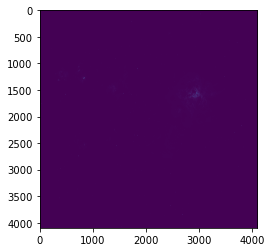

In [20]:
plt.imshow(data_imagen)

La imagen resultante es un poco pequeña y los ejes de coordenadas están dispuestos de una manera poco intuitiva. Podemos mejorar nuestra imagen ajustando algunos parámetros de la gráfica:

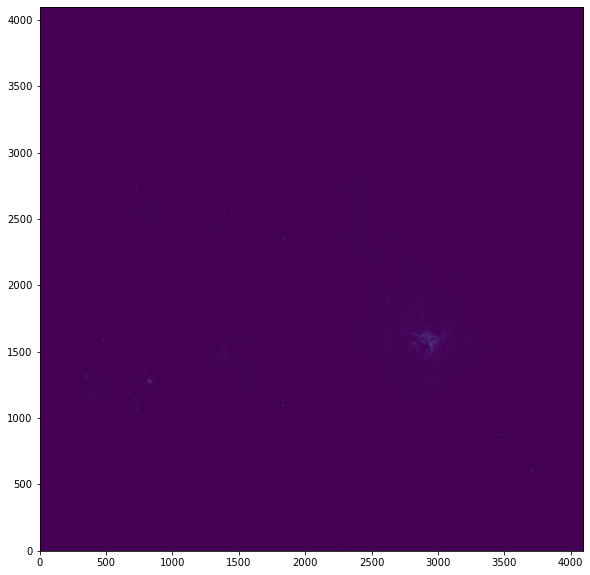

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(data_imagen, origin='lower')

Es típico en imágenes astronómica que si representamos de manera líneal la luminosidad de los píxeles la imagen sea muy oscura con una pequeñas manchas de luz en los sitios donde hay objetos muy brillantes. Para mejorar un poco el aspecto podemos procesar los datos de la imagen haciéndoles una transformación logarítmica `np.log(data_imagen)`:

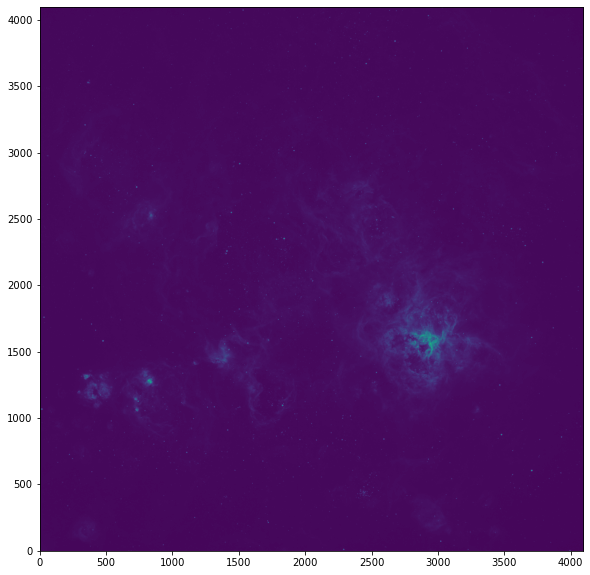

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(data_imagen), origin='lower')

Ya somos capaces de distinguir más detalles en nuestra imagen. Hay que resaltar que todavía **NO** hemos modificado nuestra imagen. Simplemente estamos cambiando la manera de representar visualmente nuestra imagen. Otra posibilidad para ver "mejor" los detalles de la imagen es hacer un estirado del histograma situando el mínimo y máximo en la escala de colores de `matplotlib`:

Text(0, 0.5, 'píxeles')

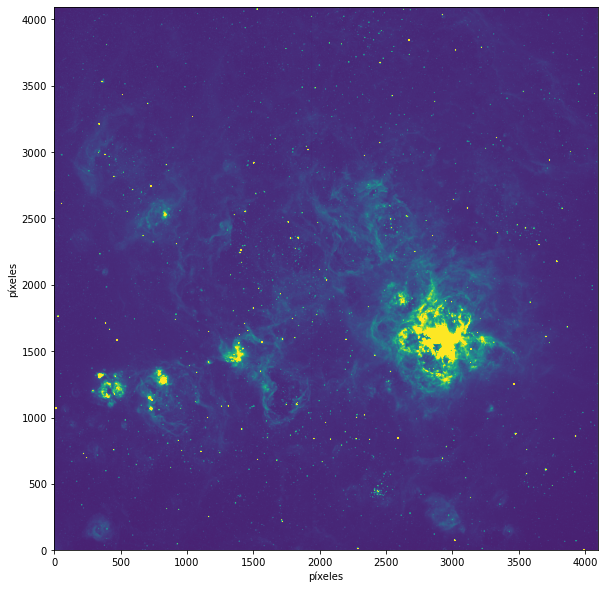

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(data_imagen, vmin=1000, vmax=2000, origin='lower')
plt.xlabel('píxeles')
plt.ylabel('píxeles')

Dicho estiramiento del histograma lo podemos hacer no solo especificando valores absolutos, sino obteniendo valores para el mínimo y máximo de la propia imagen. En el siguiente ejemplo estiramos la visualización de la imagen entre el valor *minimo* de cualquier pixel de la imagen `np.min(data_imagen)` y un 50% por encima del valor promedio `np.mean(data_imagen)*1.5`:

Text(0, 0.5, 'píxeles')

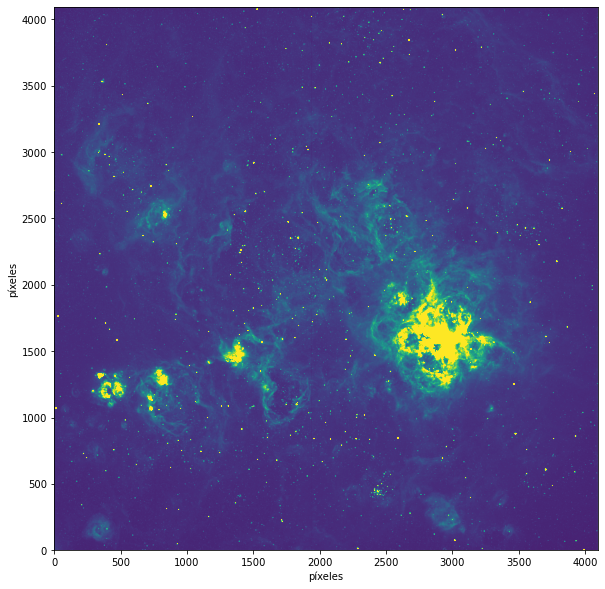

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(data_imagen, vmin=np.min(data_imagen), vmax=np.mean(data_imagen)*1.5, origin='lower')
plt.xlabel('píxeles')
plt.ylabel('píxeles')

Por último nos habremos percatado que `matplotlib` usa una [paleta de colores](https://matplotlib.org/stable/tutorials/colors/colormaps.html) por defecto entre el azul oscuro y el amarillo (llamada `viridis`) cuando realmente la imagen que estamos tratando es en tonos de gris. Podemos cambiar la paleta de colores que debe usar e incluso que represente una leyenda al lado de la imagen para tener una idea más clara de los valores que se están representando:

Text(0, 0.5, 'píxeles')

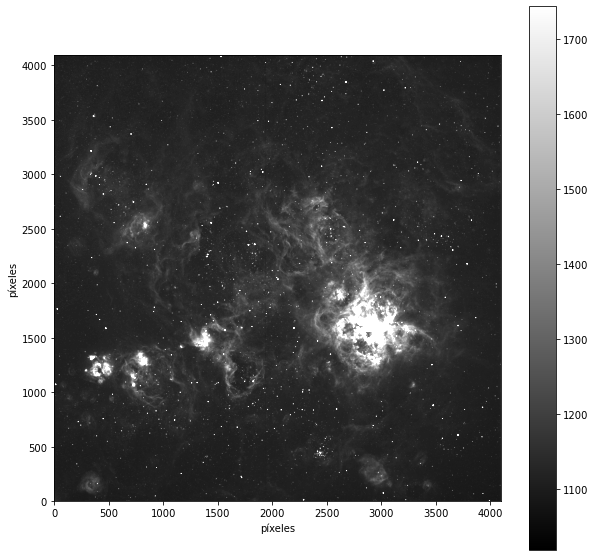

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(data_imagen, vmin=np.min(data_imagen), vmax=np.mean(data_imagen)*1.5, cmap="gray", origin='lower')
plt.colorbar()   # Añade la leyenda de la barra de color
plt.xlabel('píxeles')
plt.ylabel('píxeles')

## ¿Cómo abrir varios `FITS` a la vez?

Lo primero que tenemos que saber es que nuestras imágenes se van a almacenar en una lista. Podemos hacerlo de varias formas:
- Abrimos las imágenes como ```hdul``` y las vamos incorporando a la lista con```header``` y```data```.
- Abrimos las imágenes como```hdul``` pero solo asignamos a la lista los datos. Con esto nos ahorraremos poner```hdul[0].data``` cada vez que vayamos a operar con las imágenes.

### Creamos una lista con la ruta de todas las imágenes

Tenemos dos formas de hacerlo:
- Mediante la biblioteca ```Path```
- Mediante la biblioteca ```glob```

In [26]:
from pathlib import Path

nombreImagenes = []

directorio = Path('imagenes/calibracionImagenes/ha/')

for imagenes in directorio.iterdir():  # Iteramos pora todos los ficheros (y directorios) de un directorio
    
    nombreArchivo = str(imagenes)
    if nombreArchivo.endswith(".fits") or nombreArchivo.endswith(".fit") or nombreArchivo.endswith(".fts"):
        nombreImagenes.append(nombreArchivo)    

In [27]:
import glob
directorio = 'imagenes/calibracionImagenes/ha/*.fit'
fileList = sorted(glob.glob(directorio)) #glob genera la lista y sorted los ordena

In [28]:
nombreImagenes, fileList

(['imagenes/calibracionImagenes/ha/NGC2070-20200208@031223-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@034446-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@033255-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@032604-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@031915-300S-H-alpha.fit'],
 ['imagenes/calibracionImagenes/ha/NGC2070-20200208@030339-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@031223-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@031915-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@032604-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@033255-300S-H-alpha.fit',
  'imagenes/calibracionImagenes/ha/NGC2070-20200208@034446-300S-H-alpha.fit'])

### Lista con `hdul`

Este método implica trabajar directamente con los ```hdul``` de la imagen y tenemos que estar pendiente de poner ```[0].dat``` o ```[0].header``` para acceder a los datos de la imagen. Además, podríamos tener problemas a la hora de no cerrar el archivo al final del proceso:

In [29]:
from astropy.io import fits

hdul = []

for imagenes in fileList:
    hdul.append(fits.open(imagenes))

In [30]:
hdul[0][0].data # hdul[numero de la imagen][tanto los datos como el header del hdul estan en el primario]

array([[1159, 1167, 1196, ..., 1078, 1105, 1117],
       [1160, 1178, 1189, ..., 1099, 1093, 1111],
       [1169, 1181, 1154, ..., 1105, 1118, 1099],
       ...,
       [1138, 1132, 1096, ..., 1120, 1118, 1121],
       [1132, 1122, 1118, ..., 1115, 1128, 1137],
       [1124, 1140, 1114, ..., 1102, 1117, 1147]], dtype=uint16)

### Lista con los datos de todos los `hdul`

In [31]:
header = []
data = []

for imagenes in fileList:
    hdul = fits.open(imagenes)
    header.append(hdul[0].header)
    data.append(hdul[0].data)
    hdul.close()

In [32]:
header[0]

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2020-02-08T03:06:15' / [ISO 8601] UTC date/time of exposure start    
EXPTIME =   3.00000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   3.00000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -30.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -30.000000000000000 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

In [33]:
data[0]

array([[1159, 1167, 1196, ..., 1078, 1105, 1117],
       [1160, 1178, 1189, ..., 1099, 1093, 1111],
       [1169, 1181, 1154, ..., 1105, 1118, 1099],
       ...,
       [1138, 1132, 1096, ..., 1120, 1118, 1121],
       [1132, 1122, 1118, ..., 1115, 1128, 1137],
       [1124, 1140, 1114, ..., 1102, 1117, 1147]], dtype=uint16)

## Guardando `fits`

Para guardar nuestras imágenes usaremos el método ```.writeto()```, pero previamente si hemos dividido el ```hdul``` en dos listas con el header y data tendremos que juntarlos en un nuevo ```hdul```. Para ello crearemos un objeto para introducir los datos en un nuevo ```hdul```.

In [34]:
hdul = fits.PrimaryHDU(data=data[0], header=header[0])

Necesito un directorio para guardar mis nuevas imágenes si no lo quiero guardar en el directorio donde se encontraba la original. Para ello uso ```mkdir``` y me creo un directorio nuevo.

In [35]:
import os
directorioSalida = 'salidas/'
try:
    os.mkdir(directorioSalida)
except:
    print(f"El directorio {directorioSalida} ya existe")

El directorio salidas/ ya existe


Por último guardo mi archivo fits con el método ```.writeto()```

In [36]:
hdul.writeto(f"{directorioSalida}prueba.fit", overwrite=True)

Si quiero hacerlo con varias imágenes podemos iterar:

In [37]:
for i in range(len(fileList)):
    hdul = fits.PrimaryHDU(data=data[i], header=header[i])
    hdul.writeto(f"{directorioSalida}prueba_{i}.fit", overwrite=True)